# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from tensorflow import keras
from tensorflow.keras import layers
import warnings

warnings.filterwarnings('ignore')

# Exploratory Data Analysis

## Load Dataset for EDA

In [ ]:
data = pd.read_csv('retail_store_sales.csv')

## Summarize Data

In [ ]:
print("Dataset Preview:")
print(data.head())
print("\nDataset Info:")
data.info()
print("\nSummary Statistics (Numerical Columns):")
print(data.describe())
print("\nSummary Statistics (Categorical Columns):")
print(data.describe(include=['object']))

Dataset Preview:
  Transaction ID Customer ID       Category          Item  Price Per Unit  \
0    TXN_6867343     CUST_09     Patisserie   Item_10_PAT            18.5   
1    TXN_3731986     CUST_22  Milk Products  Item_17_MILK            29.0   
2    TXN_9303719     CUST_02       Butchers   Item_12_BUT            21.5   
3    TXN_9458126     CUST_06      Beverages   Item_16_BEV            27.5   
4    TXN_4575373     CUST_05           Food   Item_6_FOOD            12.5   

   Quantity  Total Spent  Payment Method Location Transaction Date  \
0      10.0        185.0  Digital Wallet   Online       2024-04-08   
1       9.0        261.0  Digital Wallet   Online       2023-07-23   
2       2.0         43.0     Credit Card   Online       2022-10-05   
3       9.0        247.5     Credit Card   Online       2022-05-07   
4       7.0         87.5  Digital Wallet   Online       2022-10-02   

  Discount Applied  
0             True  
1             True  
2            False  
3              

## Visualize Numerical Feature Distributions

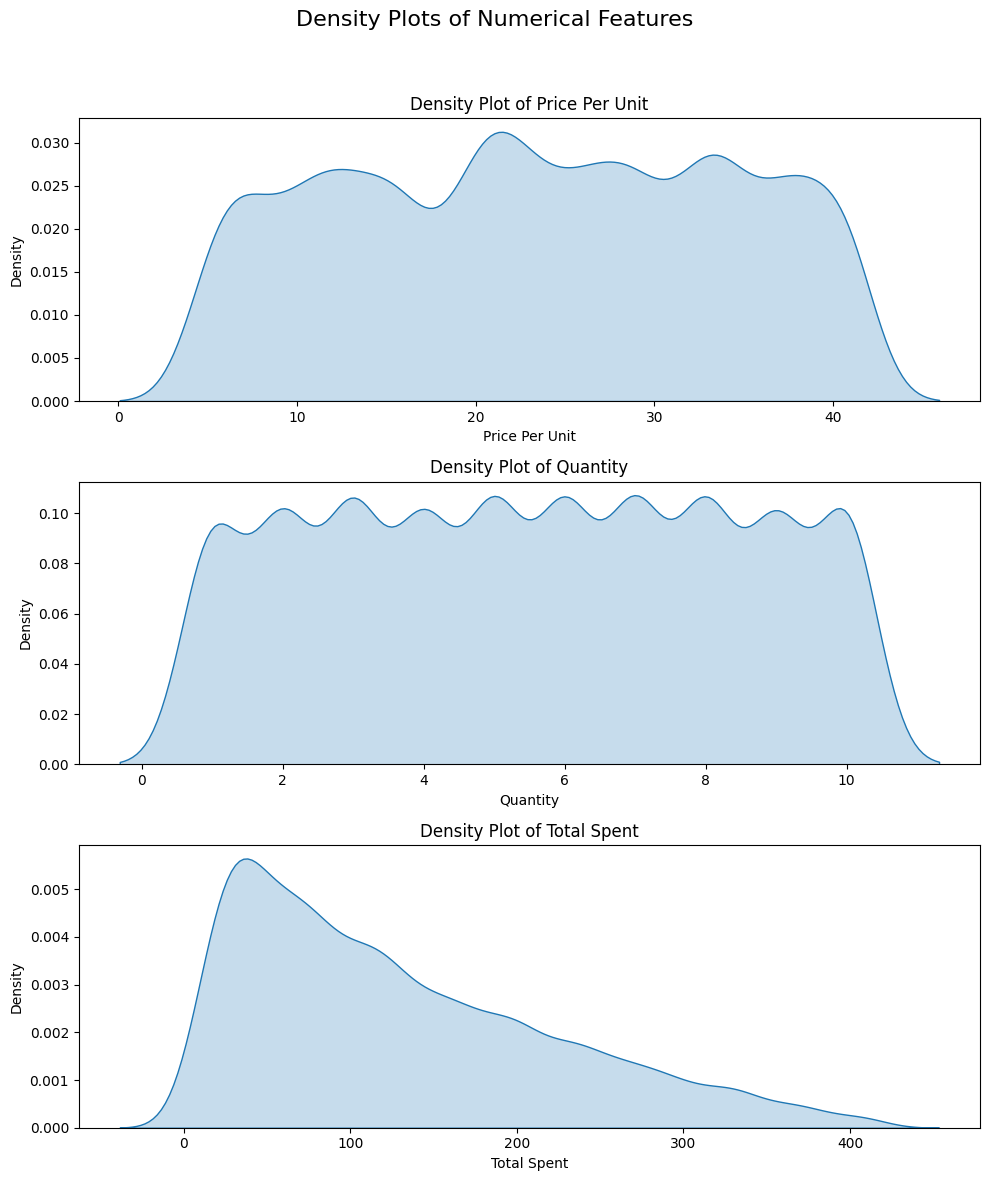

In [ ]:
Tnumerical_cols = ['Price Per Unit', 'Quantity', 'Total Spent']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
fig.suptitle('Density Plots of Numerical Features', fontsize=16)
for i, col in enumerate(numerical_cols):
    sns.kdeplot(data=data[col], ax=axes[i], fill=True)
    axes[i].set_title(f'Density Plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Visualize Categorical Feature Distributions

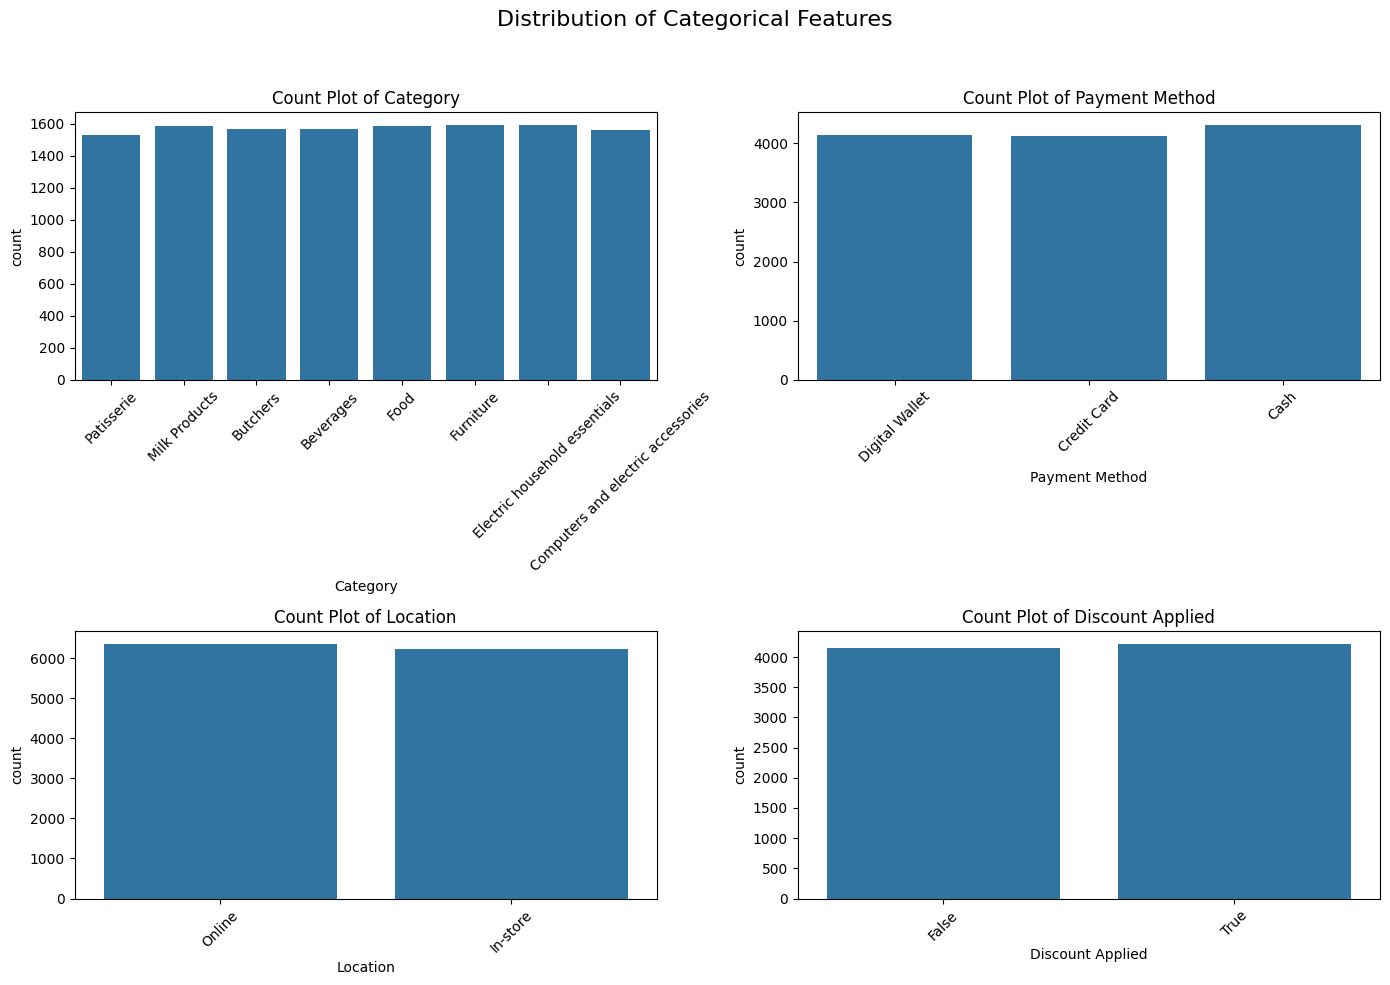


Value Counts for Category:
Category
Electric household essentials         1591
Furniture                             1591
Food                                  1588
Milk Products                         1584
Butchers                              1568
Beverages                             1567
Computers and electric accessories    1558
Patisserie                            1528
Name: count, dtype: int64

Value Counts for Payment Method:
Payment Method
Cash              4310
Digital Wallet    4144
Credit Card       4121
Name: count, dtype: int64

Value Counts for Location:
Location
Online      6354
In-store    6221
Name: count, dtype: int64

Value Counts for Discount Applied:
Discount Applied
True     4219
False    4157
Name: count, dtype: int64


In [ ]:
categorical_cols = ['Category', 'Payment Method', 'Location', 'Discount Applied']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Distribution of Categorical Features', fontsize=16)
for i, col in enumerate(categorical_cols):
    row, col_idx = i // 2, i % 2
    sns.countplot(data=data, x=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Count Plot of {col}')
    axes[row, col_idx].tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
for col in categorical_cols:
    print(f"\nValue Counts for {col}:")
    print(data[col].value_counts())

## Correlation Analysis

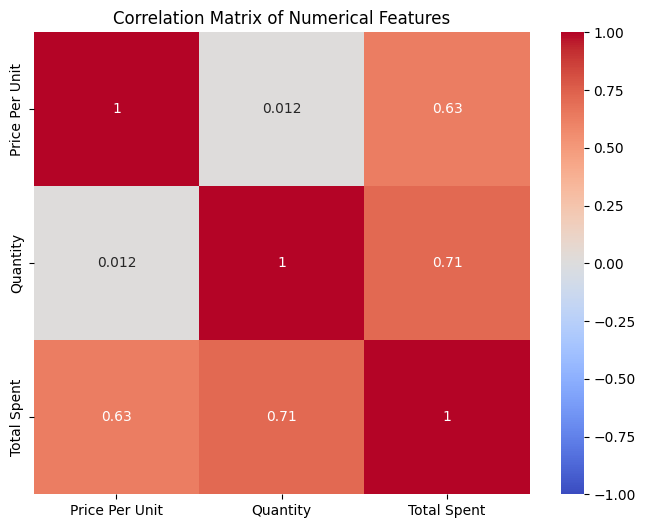


Correlation Matrix:
                Price Per Unit  Quantity  Total Spent
Price Per Unit        1.000000  0.011801     0.630902
Quantity              0.011801  1.000000     0.712069
Total Spent           0.630902  0.712069     1.000000


In [ ]:
corr_matrix = data[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()
print("\nCorrelation Matrix:")
print(corr_matrix)

## Check Imbalances


Imbalance in Discount Applied:
Discount Applied
True     0.503701
False    0.496299
Name: proportion, dtype: float64


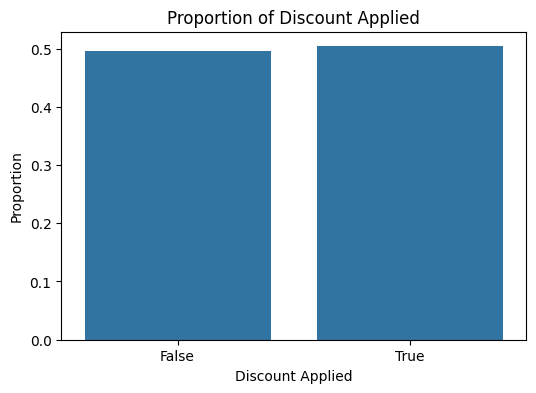


Imbalance in Category:
Category
Electric household essentials         0.126521
Furniture                             0.126521
Food                                  0.126282
Milk Products                         0.125964
Butchers                              0.124692
Beverages                             0.124612
Computers and electric accessories    0.123897
Patisserie                            0.121511
Name: proportion, dtype: float64


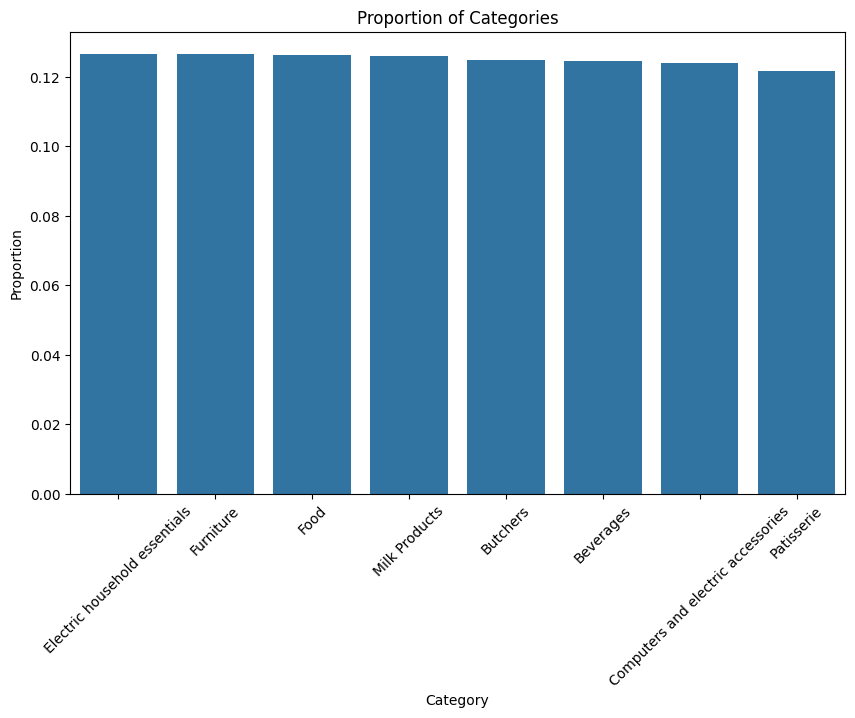

In [ ]:
print("\nImbalance in Discount Applied:")
discount_counts = data['Discount Applied'].value_counts(normalize=True)
print(discount_counts)
plt.figure(figsize=(6, 4))
sns.barplot(x=discount_counts.index, y=discount_counts.values)
plt.title('Proportion of Discount Applied')
plt.ylabel('Proportion')
plt.show()

print("\nImbalance in Category:")
category_counts = data['Category'].value_counts(normalize=True)
print(category_counts)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Proportion of Categories')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()

## EDA

In [ ]:
print("\nEDA Insights:")
print("- Strong correlation between Total Spent and Price Per Unit/Quantity, confirming their importance.")
print("- High discount usage (~70-80% True) suggests discounts drive sales.")
print("- Category imbalance (e.g., Food > Furniture) may affect model performance.")
print("- Numerical features are right-skewed, suggesting potential transformation.")


EDA Insights:
- Strong correlation between Total Spent and Price Per Unit/Quantity, confirming their importance.
- High discount usage (~70-80% True) suggests discounts drive sales.
- Category imbalance (e.g., Food > Furniture) may affect model performance.
- Numerical features are right-skewed, suggesting potential transformation.


# Load Dataset

In [ ]:
def load_data(file_path):
    """Load the retail sales dataset."""
    try:
        data = pd.read_csv("retail_store_sales.csv")
        print(f"Dataset loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
        return data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None


# Data Exploration and feature

In [ ]:
def explore_and_preprocess(data):
    """Explore and preprocess the dataset."""
    print("\n--- Data Exploration ---")
    print("\nDataset Sample:")
    print(data.head())

    missing_values = data.isnull().sum()
    print(missing_values[missing_values > 0])

    print("\n--- Data Inconsistencies ---")
    print("Duplicate rows:", data.duplicated().sum())

    # Targert
    if 'Total Spent' in data.columns:
        initial_rows = data.shape[0]
        data = data.dropna(subset=['Total Spent'])
        print(f"Dropped {initial_rows - data.shape[0]} rows with missing Total Spent.")

#valid ornot
    numerical_cols = ['Price Per Unit', 'Quantity']
    for col in numerical_cols:
        if col in data.columns:
            invalid = data[data[col] <= 0]
            if not invalid.empty:
                print(f"Warning: {len(invalid)} rows with non-positive values in {col}")
                data.loc[data[col] <= 0, col] = np.nan

    # Check discrepancies without overwriting Total Spent
    if 'Total Spent' in data.columns and 'Price Per Unit' in data.columns and 'Quantity' in data.columns:
        data['Calculated Total'] = data['Price Per Unit'] * data['Quantity']
        discrepancy = (data['Total Spent'] - data['Calculated Total']).abs().sum()
        if discrepancy > 1e-6:
            print(f"Total Spent discrepancies found: {discrepancy:.2f}")
        else:
            print("No discrepancies found between Total Spent and Price Per Unit × Quantity.")

    # Impute missing values (excluding Total Spent)
    print("\n--- Handling Missing Values ---")
    for col in data.columns:
        if col != 'Total Spent' and data[col].isnull().sum() > 0:
            missing = data[col].isnull().sum()
            if data[col].dtype in ['int64', 'float64']:
                median_val = data[col].median()
                data[col].fillna(median_val, inplace=True)
                print(f"Imputed {missing} missing values in {col} with median: {median_val}")
            else:
                mode_val = data[col].mode()[0]
                data[col].fillna(mode_val, inplace=True)
                print(f"Imputed {missing} missing values in {col} with mode: {mode_val}")

    if 'Discount Applied' in data.columns:
        data['Discount Applied'] = data['Discount Applied'].astype(str).str.lower().map({'true': 1, 'false': 0, 'nan': 0})
        print("Converted 'Discount Applied' to binary values.")


    if 'Price Per Unit' in data.columns:
        bins = [0, 10, 20, 30, 50, np.inf]
        labels = ['Low', 'Medium', 'High', 'Very High', 'Premium']
        data['Price Category'] = pd.cut(data['Price Per Unit'], bins=bins, labels=labels)
        print("Added Price Category feature.")
    #outlier
    for col in numerical_cols:
        if col in data.columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
            if not outliers.empty:
                print(f"Detected {len(outliers)} outliers in {col}")
                data.loc[(data[col] < lower_bound) | (data[col] > upper_bound), col] = np.nan
                data[col].fillna(data[col].median(), inplace=True)
                print(f"Replaced outliers in {col} with median.")

    return data

# Convert Date Columns

In [ ]:
 #Feature encoding and selection
def prepare_features(data, target_col='Total Spent'):
    """Prepare features for modeling."""
    print("\n--- Feature Encoding and Selection ---")
    cols_to_drop = ['Transaction ID', 'Transaction Date', 'Calculated Total', 'Transaction Year',
                    'Transaction Month', 'Transaction Day', 'Transaction Age']
    data = data.drop([col for col in cols_to_drop if col in data.columns], axis=1)

    X = data.drop(target_col, axis=1)
    y = data[target_col]

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    print(f"Categorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return X, y, preprocessor

#split


In [ ]:
# Split data
def split_data(X, y):
    """Split data into training and testing sets."""
    print("\n--- Splitting Dataset ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")
    return X_train, X_test, y_train, y_test

#train


In [ ]:
# Train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    """Train and evaluate multiple models."""
    print("\n--- Model Training and Evaluation ---")
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
        'Random Forest': GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid={'n_estimators': [100, 200], 'max_depth': [10, 20]},
            cv=3,
            scoring='r2'
        )
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
        print(f"Cross-Validation R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        print(f"Test RMSE: {rmse:.2f}")
        print(f"Test MAE: {mae:.2f}")
        print(f"Test MAPE: {mape:.2%}")
        print(f"Test R² Score: {r2:.4f}")

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2,
            'Predictions': y_pred,
            'Pipeline': pipeline,
            'CV_R2': cv_scores.mean()
        }

    # Neural Network
    print("\nTraining Neural Network...")
    try:
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)
        input_dim = X_train_preprocessed.shape[1]

        nn_model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.4),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1)
        ])

        nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        history = nn_model.fit(
            X_train_preprocessed, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )

        y_pred_nn = nn_model.predict(X_test_preprocessed, verbose=0).flatten()
        nn_mse = mean_squared_error(y_test, y_pred_nn)
        nn_rmse = np.sqrt(nn_mse)
        nn_mae = mean_absolute_error(y_test, y_pred_nn)
        nn_mape = mean_absolute_percentage_error(y_test, y_pred_nn)
        nn_r2 = r2_score(y_test, y_pred_nn)

        print(f"Neural Network Test RMSE: {nn_rmse:.2f}")
        print(f"Neural Network Test MAE: {nn_mae:.2f}")
        print(f"Neural Network Test MAPE: {nn_mape:.2%}")
        print(f"Neural Network Test R² Score: {nn_r2:.4f}")

        results['Neural Network'] = {
            'RMSE': nn_rmse,
            'MAE': nn_mae,
            'MAPE': nn_mape,
            'R2': nn_r2,
            'Predictions': y_pred_nn,
            'Pipeline': None,  # Neural Network doesn't use the pipeline
            'CV_R2': None  # Cross-validation not implemented for NN
        }
    except Exception as e:
        print(f"Error training Neural Network: {e}")

    return results

# result


In [ ]:
# Visualize results
def visualize_results(results, y_test):
    """Visualize model performance comparison."""
    print("\n--- Model Comparison ---")
    metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
    scores = {metric: {model: results[model][metric] for model in results} for metric in metrics}

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.bar(scores[metric].keys(), scores[metric].values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)
        if metric == 'R2':
            plt.ylim(0, 1)
        plt.ylabel(metric)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.close()

    # Actual vs Predicted Scatter Plot for Best Model
    best_model = max(scores['R2'].items(), key=lambda x: x[1])[0]
    y_pred = results[best_model]['Predictions']

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='#1f77b4')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Total Spent')
    plt.ylabel('Predicted Total Spent')
    plt.title(f'Actual vs Predicted ({best_model})')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    plt.close()

    print(f"\nBest performing model based on R² score: {best_model}")
    return best_model


In [ ]:

# Feature importance analysis
def analyze_feature_importance(X, results, best_model_name, preprocessor):
    """Analyze feature importance for the best model."""
    print("\n--- Feature Importance Analysis ---")
    try:

        feature_names = []
        numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        feature_names.extend(numerical_cols)
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        for col in categorical_cols:
            categories = encoder.categories_[categorical_cols.index(col)]
            feature_names.extend([f"{col}_{cat}" for cat in categories])

        if best_model_name in ['Random Forest', 'Decision Tree']:
            model = results[best_model_name]['Pipeline'].named_steps['model']
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                feature_importance = pd.DataFrame({
                    'Feature': feature_names[:len(importances)],
                    'Importance': importances
                }).sort_values(by='Importance', ascending=False)

                print("\nTop 10 Most Important Features:")
                print(feature_importance.head(10))

                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
                plt.title('Top 10 Feature Importance')
                plt.tight_layout()
                plt.savefig('feature_importance.png')
                plt.close()
        else:
            print(f"Using permutation importance for {best_model_name}...")
            pipeline = results[best_model_name]['Pipeline'] if results[best_model_name]['Pipeline'] else None
            if pipeline:
                perm_importance = permutation_importance(pipeline, X, results[best_model_name]['Predictions'], n_repeats=10, random_state=42)
                feature_importance = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': perm_importance.importances_mean
                }).sort_values(by='Importance', ascending=False)

                print("\nTop 10 Most Important Features (Permutation Importance):")
                print(feature_importance.head(10))

                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
                plt.title('Top 10 Feature Importance (Permutation)')
                plt.tight_layout()
                plt.savefig('feature_importance_permutation.png')
                plt.close()
    except Exception as e:
        print(f"Error in feature importance analysis: {e}")



In [ ]:
# Main function
def main():
    """Main function to run the analysis."""
    print("=== Retail Store Sales Analysis ===")
    data = load_data('retail_store_sales.csv')
    if data is None:
        return

    preprocessed_data = explore_and_preprocess(data)
    X, y, preprocessor = prepare_features(preprocessed_data)
    X_train, X_test, y_train, y_test = split_data(X, y)
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)
    best_model = visualize_results(results, y_test)
    analyze_feature_importance(X, results, best_model, preprocessor)
    print("\n=== Analysis Complete ===")

if __name__ == "__main__":
    main()

=== Retail Store Sales Analysis ===
Dataset loaded successfully with 12575 rows and 11 columns.

--- Data Exploration ---

Dataset Sample:
  Transaction ID Customer ID       Category          Item  Price Per Unit  \
0    TXN_6867343     CUST_09     Patisserie   Item_10_PAT            18.5   
1    TXN_3731986     CUST_22  Milk Products  Item_17_MILK            29.0   
2    TXN_9303719     CUST_02       Butchers   Item_12_BUT            21.5   
3    TXN_9458126     CUST_06      Beverages   Item_16_BEV            27.5   
4    TXN_4575373     CUST_05           Food   Item_6_FOOD            12.5   

   Quantity  Total Spent  Payment Method Location Transaction Date  \
0      10.0        185.0  Digital Wallet   Online       2024-04-08   
1       9.0        261.0  Digital Wallet   Online       2023-07-23   
2       2.0         43.0     Credit Card   Online       2022-10-05   
3       9.0        247.5     Credit Card   Online       2022-05-07   
4       7.0         87.5  Digital Wallet   Onlin

# Analysis Complete

In [ ]:
print("\n=== Analysis Complete ===")


=== Analysis Complete ===
